# Crude Oil Analysis featuring multi-method forecast

### Sama Alnassiry

## 1. To begin our analysis, we will import all necessary libraries and filters:

In [1]:
import pandas as pd #data processing
import pastas as ps #alt option
import matplotlib.pyplot as plt #plotting
import numpy as np #linear algebra
from sklearn.metrics import mean_squared_error as rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error as mase
import statsmodels.api as sm
import seaborn as sns #plotting
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import pymannkendall as mk #Mann-Kendall trend test
from statsmodels.tsa.stattools import adfuller #Augumented Dickey-Fuller
from prophet import Prophet #time series predition library
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from IPython.display import display
pd.options.mode.chained_assignment = None  # default='warn'
from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib notebook

## 2. Open dataset, create dataframe and display:

In [2]:
pd.options.display.max_seq_items = None
path_to_data = '/Users/samaalnassiry/Desktop/Crude Oil Analysis/clean-wide-final.csv'
open_data = pd.read_csv(path_to_data)
open_data.head() #reading first few rows

,_LOCATION_,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag_Codes,country,total_prod_value
0,Angola,OILPROD,TOT,KTOE,A,2015,90844.0115,NaN,AGO,1.531998e+06
1,Angola,OILPROD,TOT,KTOE,A,2001,37234.6504,NaN,AGO,1.531998e+06
2,Angola,OILPROD,TOT,KTOE,A,2003,44651.1548,NaN,AGO,1.531998e+06
3,Angola,OILPROD,TOT,KTOE,A,2013,87578.8709,NaN,AGO,1.531998e+06
4,Angola,OILPROD,TOT,KTOE,A,2019,66442.8144,NaN,AGO,1.531998e+06


## 3. Create a country selection function:

In [3]:
def country_selector(x): #parses through the dataframe to return only data from one country
  internal_country = open_data.loc[open_data['_LOCATION_']==x]
  time_val = internal_country[['TIME','Value']].sort_values(by='TIME', ascending=True) #pulls time 
  #and production value
 #returns by time ascending
  roc_time_val = time_val.Value.pct_change() #calculates the rate of change of production
  time_val.insert(2,'Change',roc_time_val,True) #appends the ROC
  return time_val

country = country_selector('United States')
print(country)


      TIME        Value    Change
1825  2001  295670.5634       NaN
1838  2002  292823.9012 -0.009628
1843  2003  289518.4665 -0.011288
1829  2004  276931.1563 -0.043477
1833  2005  263918.1384 -0.046990
1832  2006  260029.9388 -0.014733
1841  2007  258101.8547 -0.007415
1830  2008  252986.1288 -0.019821
1834  2009  273202.0805  0.079909
1837  2010  279225.0185  0.022046
1827  2011  287590.3824  0.029959
1828  2012  332009.6794  0.154453
1826  2013  380518.6640  0.146107
1836  2014  446109.6887  0.172373
1839  2015  472634.8512  0.059459
1835  2016  446538.2628 -0.055215
1824  2017  470279.0475  0.053166
1842  2018  551042.2788  0.171735
1831  2019  613230.3818  0.112855
1844  2020  565766.3586 -0.077400
1840  2021  559454.6637 -0.011156


## 3. Plot the current production values and ROC:

<IPython.core.display.Javascript object>


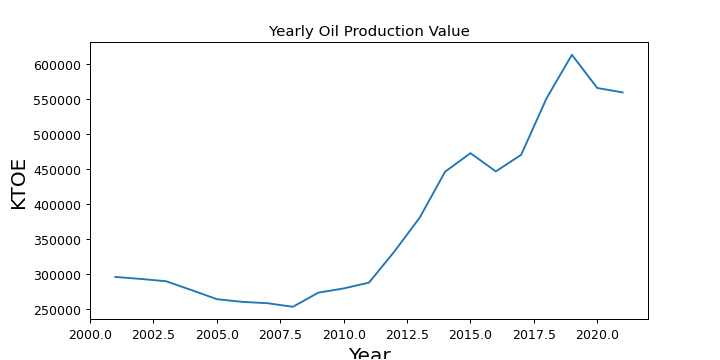

In [4]:
#Time vs production line plot
plt.figure(figsize=(8,4))
sns.lineplot(data=country, x = 'TIME' , y = 'Value')
plt.xlabel('Year', fontsize='16', horizontalalignment='center')
plt.ylabel('KTOE',fontsize='16', horizontalalignment='center')
plt.title('Yearly Oil Production Value')
plt.show()

<IPython.core.display.Javascript object>


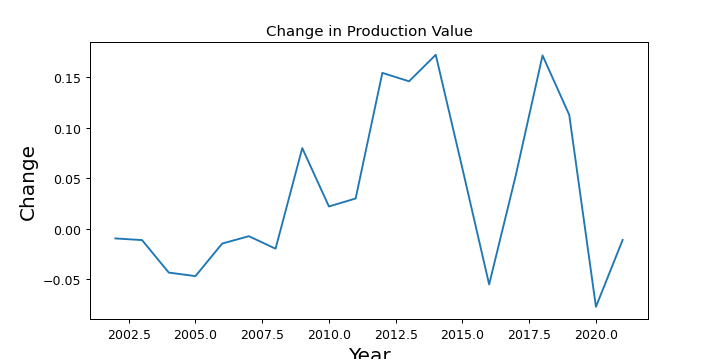

In [5]:
#Time vs production change line plot
plt.figure(figsize=(8,4))
sns.lineplot(data=country, x = 'TIME' , y = 'Change')
plt.xlabel('Year', fontsize='16', horizontalalignment='center')
plt.ylabel('Change',fontsize='16', horizontalalignment='center')
plt.title('Change in Production Value')
plt.show()


## 4. Forecast with Prophet:

In [6]:
country = country.rename(columns = {'TIME':'ds','Value':'y'}) #converting values to fit prophet
#Time series model
model = Prophet()
model.fit(country[['ds','y']])


01:04:17 - cmdstanpy - INFO - Chain [1] start processing
01:04:17 - cmdstanpy - INFO - Chain [1] done processing


## 5. Plot initial forecast:

<IPython.core.display.Javascript object>


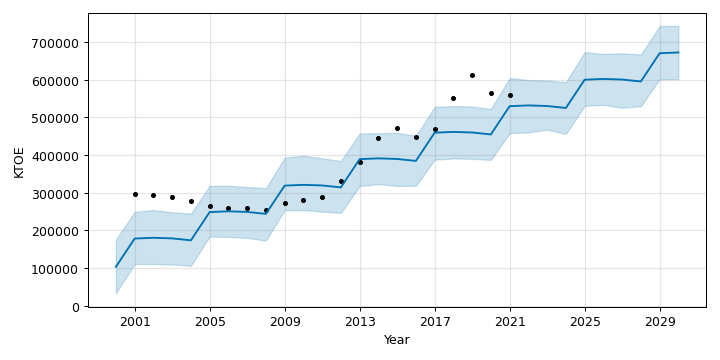

In [7]:
#Future dataframe
future = model.make_future_dataframe(periods=60,freq='Y')

forecast = model.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(12)
forecast.drop(forecast.index[:50],inplace=True)\

fig1 = model.plot(forecast, xlabel='Year', ylabel='KTOE',
    figsize=(8, 4))


# Annnnd we're done!

### ....not quiet yet.

### The information above is useful for looking at a country's performance at a quick glance but won't give us more complex insights.

### Next we will perform more complex analysis involving trends, seasonality,  time series, exponential smoothing and ARIMA.

#### *Note: The forecasting results are completely dependant on the country selected and adjustments made to certain values ( i.e lags, seasonality, smoothing level etc) based on preliminary insight results are highly encouraged. 



## 6. Mann-Kendall testing for trend availability: 

In [8]:

#Mann-Kendall Test on present day data, H1 = a trend is avaliable in the series
#H0 = No trend is avaliable

print(mk.original_test(country.y))

Mann_Kendall_Test(trend='increasing', h=True, p=0.0002038302731313113, z=3.7142214163244605, Tau=0.5904761904761905, s=124.0, var_s=1096.6666666666667, slope=17538.566476666667, intercept=120284.89863333333)


## 7. Augmented Dickey-Fuller test for stationarity:

In [9]:
adftest= adfuller(country['y'], autolag='AIC', regression='ct')
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

ADF-Statistic: -1.9371696308782758
P-Value: 0.6351974375937811
Number of lags: 2
Number of observations: 18
Critical Values: {'1%': -4.572463998628258, '5%': -3.6900701783264744, '10%': -3.2866460905349797}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


## 8. Spearman's correlation testing:

<IPython.core.display.Javascript object>


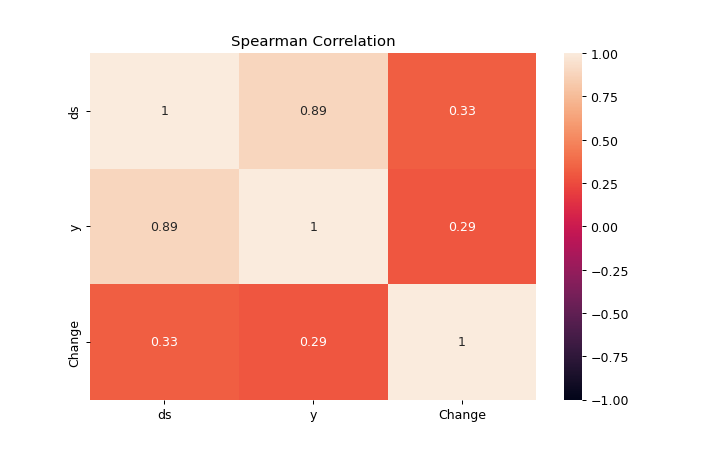

In [10]:
#Spearman's correlation
def display_correlation(df):
    r = df.corr(method="spearman")
    plt.figure(figsize=(8,5))
    heatmap = sns.heatmap(df.corr(), vmin=-1, 
                      vmax=1, annot=True)
    plt.title("Spearman Correlation")
    return(r)
spr = display_correlation(country)

## 9. Autocorrelation function, partial autocorrelation function:

<IPython.core.display.Javascript object>


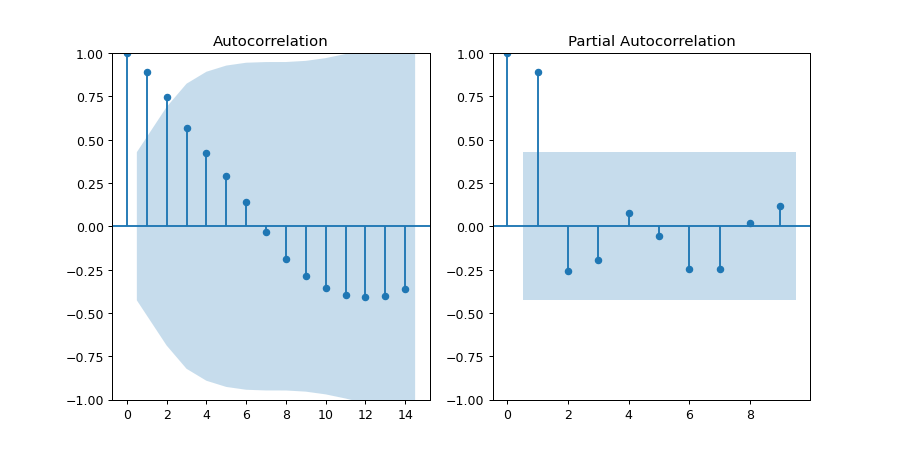

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
#ACF
sm.graphics.tsa.plot_acf(country['y'], ax=ax[0])
#PACF
sm.graphics.tsa.plot_pacf(country['y'],lags = 9, ax=ax[1])
plt.show()

## 10. Preping data for exponential smoothing:

In [12]:
#Exponential Smoothing
#30% of the data will be held for training
df = pd.DataFrame(country[['ds','y']])
df = df.rename(columns = {'ds':'Year','y':'KTOE'})

#Sets the frequency of the enteries, turns years into datetime and index
df['Year'] = pd.date_range(start='2001-12-31', periods=21, freq='A-DEC')
df.set_index('Year', inplace = True)


dfx = df #copy of full original df
test = dfx.tail(6) #holdout data
df = dfx[:-6] #training data
pred = test.copy()
display(df,test)

,KTOE
Year,
2001-12-31,295670.5634
2002-12-31,292823.9012
2003-12-31,289518.4665
2004-12-31,276931.1563
2005-12-31,263918.1384
2006-12-31,260029.9388
2007-12-31,258101.8547
2008-12-31,252986.1288
2009-12-31,273202.0805


,KTOE
Year,
2016-12-31,446538.2628
2017-12-31,470279.0475
2018-12-31,551042.2788
2019-12-31,613230.3818
2020-12-31,565766.3586
2021-12-31,559454.6637


## 11. Simple exponential smoothing:

####  *Note: Provides a stationary forecast, not ideal for forecasting oil production but will be necessary to demonstrate future steps.

In [13]:
ses = SimpleExpSmoothing(df['KTOE'])
alpha = 0.8
smooth = 0.8
model = ses.fit(smoothing_level = alpha, optimized=False)
df['SES'] = model.fittedvalues
stationaryforecast = pd.DataFrame(model.forecast(6))
df.head()

,KTOE,SES
Year,,
2001-12-31,295670.5634,295670.563400
2002-12-31,292823.9012,295670.563400
2003-12-31,289518.4665,293393.233640
2004-12-31,276931.1563,290293.419928
2005-12-31,263918.1384,279603.609026


## 12. Double exponential smoothing, Holt's method:

In [14]:
# Perform double exponential smoothing
model = ExponentialSmoothing(df['KTOE'],trend= 'add',freq = 'A-DEC')
des_model = model.fit(smoothing_level=alpha, smoothing_trend=smooth)
df2 =df
df2['DES']=des_model.fittedvalues
df2.head()

,KTOE,SES,DES
Year,,,
2001-12-31,295670.5634,295670.563400,296911.382650
2002-12-31,292823.9012,295670.563400,291795.821190
2003-12-31,289518.4665,293393.233640,289153.350344
2004-12-31,276931.1563,290293.419928,286214.182755
2005-12-31,263918.1384,279603.609026,269615.364146


## 13. Triple exponential smoothing, Holt-Winter's method:


In [15]:
# Perform triple exponential smoothing
model = ExponentialSmoothing(df2['KTOE'], trend='mul',freq = 'A-DEC', seasonal='mul', seasonal_periods=2)
tes_model = model.fit(smoothing_level=alpha, smoothing_trend=smooth)
model = model.fit()
df3 = df2
df3['TES'] = tes_model.fittedvalues
df3.head()

,KTOE,SES,DES,TES
Year,,,,
2001-12-31,295670.5634,295670.563400,296911.382650,277058.291394
2002-12-31,292823.9012,295670.563400,291795.821190,303199.191605
2003-12-31,289518.4665,293393.233640,289153.350344,305068.994606
2004-12-31,276931.1563,290293.419928,286214.182755,281940.821037
2005-12-31,263918.1384,279603.609026,269615.364146,274070.908775


## 14. Exponential forecast:

In [16]:
d = pd.DataFrame(model.forecast(6))
forecast = pd.DataFrame(data=d)
forecast.index.names = ['Year']
forecast = forecast.rename(columns={forecast.columns[0]:'Forecast'})

forecast.head()

,Forecast
Year,
2016-12-31,520068.615505
2017-12-31,575032.513469
2018-12-31,632489.166905
2019-12-31,699334.327326
2020-12-31,769211.089318


## 15. ARIMA:

In [17]:
train_arima = df['KTOE']
test_arima = test['KTOE']

history = [x for x in train_arima]
y = test_arima
predictions = []
# rolling forecasts
for i in range(0, len(y)):
    # predict
    model = ARIMA(history, order=(1,2,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
test['ARIMA'] = predictions
    

## 16. Plotting smoothing and forecasting:

<IPython.core.display.Javascript object>


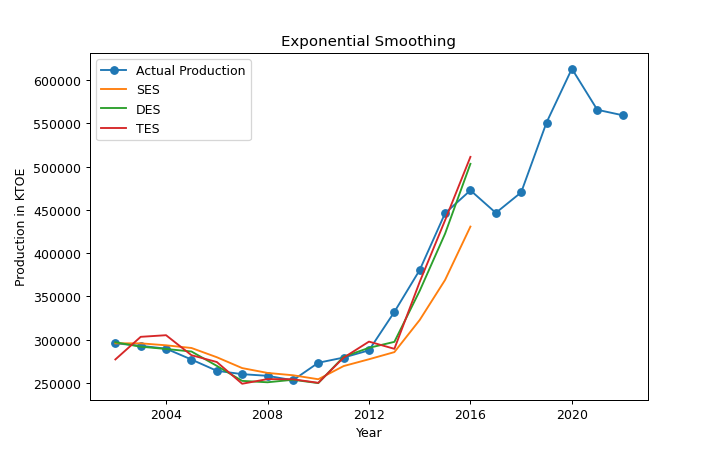

<IPython.core.display.Javascript object>


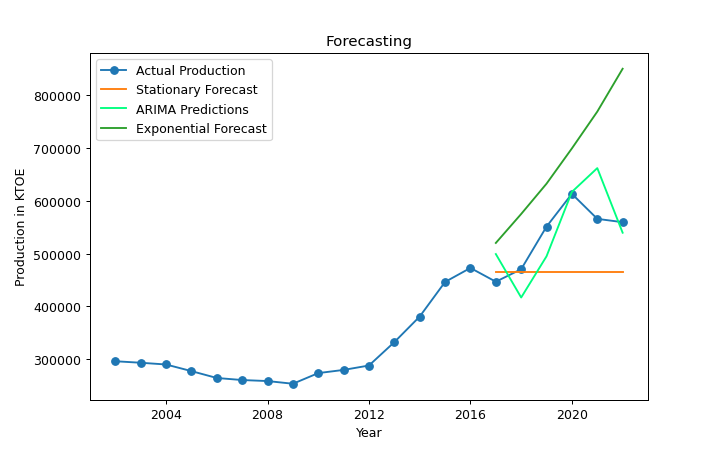

In [18]:
#Exponential Smoothing Plot
plt.figure(figsize=(8, 5))
plt.plot(dfx['KTOE'], label='Actual Production', marker='o')
plt.plot(df['SES'], label='SES')
plt.plot(df2['DES'], label='DES')
plt.plot(df3['TES'], label='TES')
plt.xlabel('Year')
plt.ylabel('Production in KTOE')
plt.title('Exponential Smoothing')
plt.legend()
plt.show()

#Forecasting plot
plt.figure(figsize=(8, 5))
plt.plot(dfx['KTOE'], label='Actual Production', marker='o')
plt.plot(stationaryforecast, label='Stationary Forecast')
plt.plot(test['ARIMA'], color='springgreen',label='ARIMA Predictions')
plt.plot(forecast, label='Exponential Forecast')
plt.xlabel('Year')
plt.ylabel('Production in KTOE')
plt.title('Forecasting')
plt.legend()
plt.show()

## 15. Visualize actual vs predicted values of forecast on training sets:

<IPython.core.display.Javascript object>


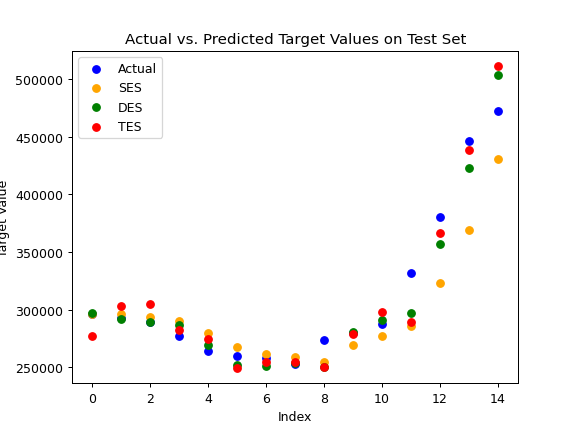

In [19]:
y_t =  df3['KTOE']
y_ses = df3['SES']
y_des = df3['DES']
y_tes = df3['TES']
y_arm = test['ARIMA']
fig, ax = plt.subplots()
ax.scatter(range(len(y_t)), y_t, color='blue', label='Actual')
ax.scatter(range(len(y_ses)), y_ses, color='orange', label='SES')
ax.scatter(range(len(y_des)), y_des, color='green', label='DES')
ax.scatter(range(len(y_tes)), y_tes, color='red', label='TES')
ax.set_xlabel('Index')
ax.set_ylabel('Target Value')
ax.set_title('Actual vs. Predicted Target Values on Test Set')
ax.legend()
plt.show()

##  16. Visualize the actual vs predicted values of the forecast on test set:

<IPython.core.display.Javascript object>


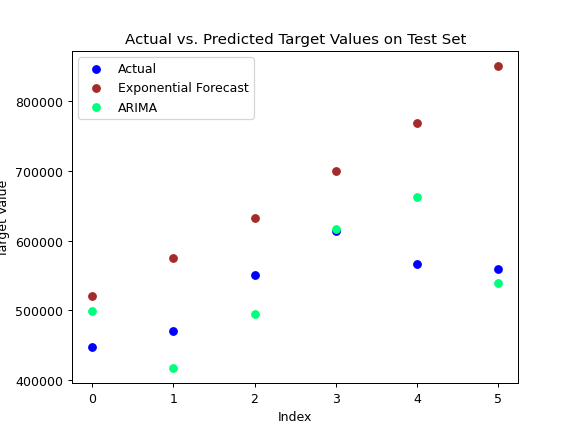

In [20]:
y_true = test['KTOE']
y_pred = forecast['Forecast'] 
fig, ax = plt.subplots()
ax.scatter(range(len(y_true)), y_true, color='blue', label='Actual')
ax.scatter(range(len(y_pred)), y_pred, color='brown', label='Exponential Forecast')
ax.scatter(range(len(y_arm)), y_arm, color='springgreen', label='ARIMA')
ax.set_xlabel('Index')
ax.set_ylabel('Target Value')
ax.set_title('Actual vs. Predicted Target Values on Test Set')
ax.legend()
plt.show()

## 17. Compute accuracy of models:

In [21]:
# Compute Accuracy Values 

def getAccuracy(x,y):
    rmse_p = rmse(x,y,squared = False)
    mape_p = mape(x,y)*100
    mase_p = mase(x,y,y_train=y)
    data = {'Property':['Root Mean Squared Error','Mean Absolute Scaled Error','Mean Absolute Percentage Error'],
        'Value':[rmse_p,mase_p,mape_p]
        }
    ds= pd.DataFrame(data)
    ds = ds.set_index('Property')
    return ds


SES = getAccuracy(y_ses,y_t)
DES = getAccuracy(y_des,y_t)
TES = getAccuracy(y_tes,y_t)
forc = getAccuracy(y_pred,y_true)
arim = getAccuracy(y_arm, y_true)
display(SES.style.set_caption('SES Accuracy'),
        DES.style.set_caption('DES Accuracy'),
        TES.style.set_caption('TES Accuracy'),
        forc.style.set_caption('Exponential Forecast Accuracy'),
        arim.style.set_caption('ARIMA Forecast Accuracy'))



,Value
Property,
Root Mean Squared Error,30901.527011
Mean Absolute Scaled Error,1.119063
Mean Absolute Percentage Error,6.557300


,Value
Property,
Root Mean Squared Error,16483.509225
Mean Absolute Scaled Error,0.617959
Mean Absolute Percentage Error,3.556661


,Value
Property,
Root Mean Squared Error,18572.931119
Mean Absolute Scaled Error,0.755401
Mean Absolute Percentage Error,4.515703


,Value
Property,
Root Mean Squared Error,161517.812467
Mean Absolute Scaled Error,3.176316
Mean Absolute Percentage Error,19.702410


,Value
Property,
Root Mean Squared Error,55503.286272
Mean Absolute Scaled Error,1.067092
Mean Absolute Percentage Error,8.934993



## Which model is most accurate? That depends on the country. 

### One suggestion is to not calculate accuracy including 2020, as that is an inflection point that the model may not be able to account for considering a global pandemic. Another suggestion maybe to consider blinding the model of specific events surrounding your country of choice.

## Below is the accuracy analysis without 2020:

In [22]:
forc20 = getAccuracy(y_true.iloc[:-2],y_pred.iloc[:-2])
arim20 = getAccuracy(y_arm.iloc[:-2], y_true.iloc[:-2])

display(forc20.style.set_caption('Exponential Forecast Accuracy Adjusted to 2020'))
display(arim20.style.set_caption('ARIMA Forecast Accuracy Adjusted to 2020'))

,Value
Property,
Root Mean Squared Error,87217.381322
Mean Absolute Scaled Error,1.446880
Mean Absolute Percentage Error,16.890765


,Value
Property,
Root Mean Squared Error,46947.263764
Mean Absolute Scaled Error,0.747237
Mean Absolute Percentage Error,8.842121


## Through this new prespective, we can make better adjusted decisions whether or not the model is truly aacurate.